# Bootstrap Algorithm for H.D.D Stochastic Copulas Model Implementation:

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly
import sklearn
import particles
import particles.state_space_models as ssm
import particles.distributions as dists

Toy example : 

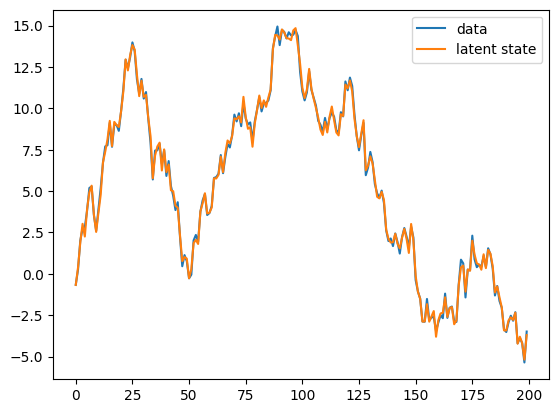

In [2]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists

class ToySSM(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0 
        return dists.Normal()  # X_0 ~ N(0, 1)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.Normal(loc=xp)  # X_t ~ N( X_{t-1}, 1)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1}) 
        return dists.Normal(loc=x, scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)
    

my_model = ToySSM(sigma=0.2)
x, y = my_model.simulate(200)  # sample size is 200
plt.plot(y, label='data')
plt.plot(x, label='latent state')
plt.legend()
plt.show()


In [7]:
alg = particles.SMC(fk=ssm.Bootstrap(ssm=my_model, data=y), N=200)
alg.run()

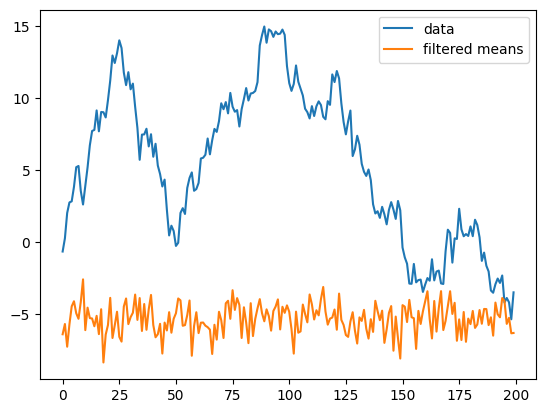

In [8]:
# Plot the filtered means
plt.plot(y, label='data')
plt.plot(alg.X, label='filtered means')
plt.legend()
plt.show()


In [9]:
# Define the State-Space Model
class CopulaSSM(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0 
        return dists.Normal()  # X_0 ~ N(0, 1)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.Normal(loc=xp)  # X_t ~ N( X_{t-1}, 1)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1}) 
        return dists.Normal(loc=x, scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)
    
    def __init__(self, sigma, dim, cov_matrix):
        super()
        self.sigma = sigma
        self.dim = dim
        self.cov_matrix = cov_matrix


In [10]:
# Parameters for the model
dim = 1 # Adjust based on your high-dimensional model
sigma = 0.5
cov_matrix = np.eye(dim) * 0.1

# Instantiate the model
copula_model = CopulaSSM(sigma=sigma, dim=dim, cov_matrix=cov_matrix)

print("Model instantiated successfully.")
# Simulate data
sim_data = copula_model.simulate(200)  # Simulate 200 samples
u_t, Λ_t = sim_data

# Bootstrap filter
N_particles = 500
algorithm = particles.SMC(fk=ssm.Bootstrap(ssm=copula_model, data=u_t), N=N_particles)
algorithm.run()

Model instantiated successfully.


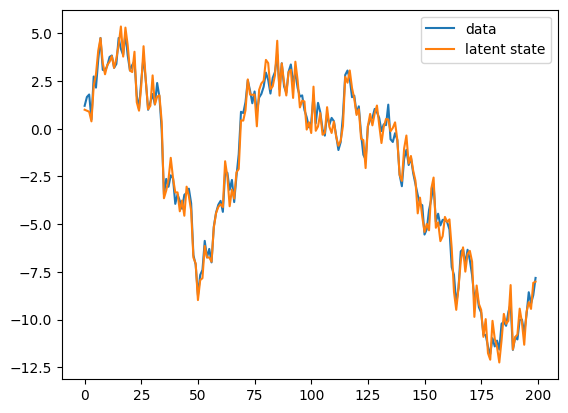

In [12]:
plt.plot(u_t, label='data')
plt.plot(Λ_t, label='latent state')

plt.legend()
plt.show()


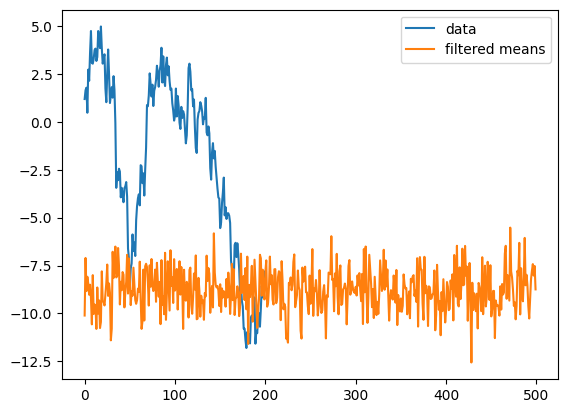

In [13]:
plt.plot(u_t, label='data')
plt.plot(algorithm.X, label='filtered means')
plt.legend()
plt.show()


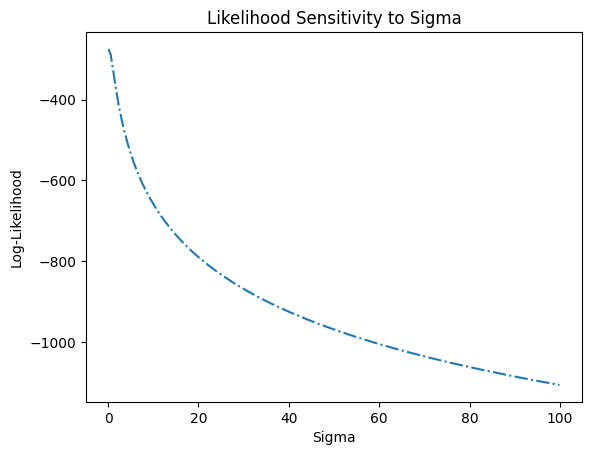

In [14]:
# Analyze likelihood for different parameter settings
params_to_vary = {'sigma': np.arange(0.1, 100, 0.1)}
likelihoods = []
for sigma_value in params_to_vary['sigma']:
    copula_model = CopulaSSM(sigma=sigma_value, dim=dim, cov_matrix=cov_matrix)
    alg = particles.SMC(fk=ssm.Bootstrap(ssm=copula_model, data=u_t), N=N_particles)
    alg.run()
    likelihoods.append(alg.logLt)

# Plot the likelihood results
import matplotlib.pyplot as plt
plt.plot(params_to_vary['sigma'], likelihoods, '-.')
plt.xlabel('Sigma')
plt.ylabel('Log-Likelihood')
plt.title('Likelihood Sensitivity to Sigma')
plt.show()


High Dimensional Copulas model 

In [138]:
from particles import state_space_models as ssms
from particles import distributions as dists

In [205]:
class CopulaSSM(ssm.StateSpaceModel):
    default_params = {'n': 1, 'p': 1, 'k': 1} 


    def PX0(self):  # Distribution of X_0 
        return dists.MvNormal(loc=np.zeros(self.n), cov=np.eye(self.n))  # X_0 ~ N(0, 1)
    

    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        # In our case the state is At.

        # Gamma : diagonal matrix
        cov_mat_eta = np.eye(self.n)
        for i in range(self.n):
            cov_mat_eta[i, i] = dists.InvGamma(a=20.0, b=0.25).rvs(size=1)
        eta = dists.Normal(0, cov_mat_eta) # eta ~ N(0, cov_mat_eta)
        # mu
        mu = np.array([dists.Normal(loc=0.4, scale=2).rvs() for _ in range(self.n)]).T.reshape(self.n, 1)
        # phi_lambda : diagonal matrix
        phi_lambda = np.eye(self.n)
        for i in range(self.n):
            phi_lambda[i, i] = dists.Normal(loc=0.985, scale=0.001).rvs(size=1)
        return dists.MvNormal(loc= mu + np.dot(phi_lambda, (xp.T - mu)), cov=cov_mat_eta) # X_t ~ N( X_{t-1}, 1)
    

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1})
        x_t = np.zeros(self.n)
        beta = np.zeros(self.k) # we take beta = 0 according to the paper
        z_t = dists.MvNormal(loc=0, cov=np.eye(self.p + self.k)).rvs(size=1).T
        epsilon_t = np.zeros(self.n)
        for i in range(self.n):
            epsilon_t[i] = dists.Normal(loc=0, scale=1).rvs(size=1)

        # Here we only use constant loading factors, we must implement a GIBBS Sampler (section in the paper)
        lambda_t = np.zeros((self.n, self.p))
        for i in range(self.n):
                lambda_t[i, :] = dists.MvNormal(loc=0.2*np.ones(self.p), cov= 2 * np.eye(self.p), scale=1).rvs(size=1)
        # volatility
        sigma_t = np.zeros(self.n)
        for i in range(self.n):
            sigma_t[i] = 1 / np.sqrt(1 + np.dot(lambda_t[i], lambda_t[i]))

        # scaling factor loadings
        for i in range(self.n):
            lambda_t[i] = lambda_t[i] / np.sqrt(1 + np.dot(lambda_t[i], lambda_t[i]))

        for i in range(self.n):
            x_t[i] = np.dot(lambda_t[i], z_t[:self.p]) + epsilon_t[i] * sigma_t[i]
        
        # u_it = P(x_it = 1) (P is gaussian cdf for now, but we must use grouped student t distribution, skewed one and compare)
        # u_t = np.zeros(self.n)
        # for i in range(self.n):
            # u_t[i] = ??
        
        # we want to return uit = P(xit | theta)
        return dists.MvNormal(loc=x_t, scale=sigma_t)

In [206]:
# Test the model

# Parameters for the model
n = 3
p = 5
k = 1

# Instantiate the model
copula_model = CopulaSSM(n=n, p=p, k=k)

print("Model instantiated successfully.")

# Simulate data
sim_data = copula_model.simulate(200)  # Simulate 200 samples
u, Λ = sim_data

print("Data simulated successfully.")



Model instantiated successfully.
Data simulated successfully.


In [207]:
print(len(u))
print(len(Λ))
print(u[0].shape)
print(Λ[0].shape)

200
200
(1, 3)
(1, 3)


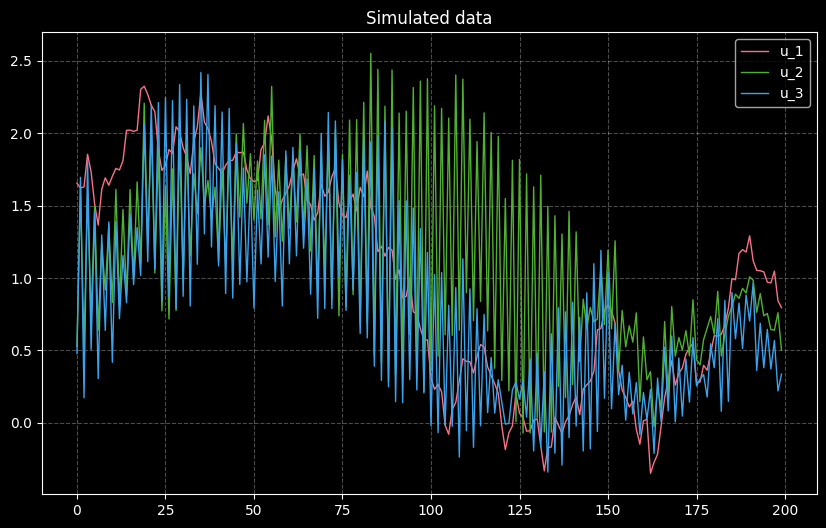

In [213]:
# plot the simulated data and the latent state Λ_t 
import seaborn as sns
#plot u1 to u10 and Λ1 to Λ10
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
colors = sns.color_palette("husl", n)
for i in range(n):
    plt.plot([u[j][0,i] for j in range(len(u))], label=f'u_{i+1}', linewidth=1.0, color=colors[i])
plt.title("Simulated data")
plt.grid(alpha=0.3, linestyle='--')
# black background
plt.legend()
plt.show()




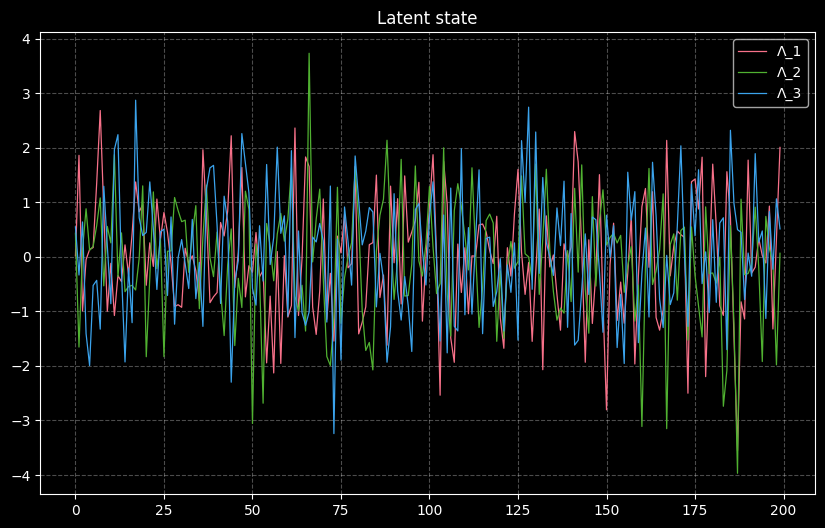

In [214]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
for i in range(n):
    plt.plot([Λ[j][0,i] for j in range(len(Λ))], label=f'Λ_{i+1}', linewidth=0.9, color=colors[i])
plt.title("Latent state")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.show()


In [221]:
# Run the Bootstrap filter
N_particles = 1
algorithm = particles.SMC(fk=ssm.Bootstrap(ssm=copula_model, data=u), N=N_particles)
algorithm.run()


In [222]:
algorithm.X.shape

(3, 3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

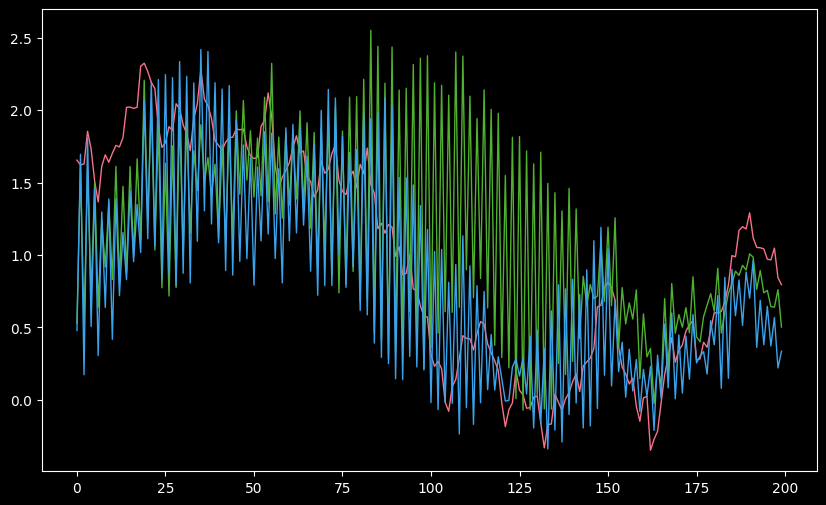